In [1]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pylab as pl

In [2]:
TYPE_LIST =  [x.upper() for x in ['Grass','Fire','Water','Bug','Normal','Poison',
            'Electric','Ground','Fairy','Fighting','Psychic',
            'Rock','Ghost','Ice','Dragon','Dark','Steel','Flying']]

COLOR_LIST = ['#8ED752', '#F95643', '#53AFFE', '#C3D221', '#BBBDAF', '#AD5CA2', 
              '#F8E64E', '#F0CA42', '#F9AEFE', '#A35449', '#FB61B4', '#CDBD72', 
              '#7673DA', '#66EBFF', '#8B76FF', '#8E6856', '#C3C1D7', '#75A4F9']

COLOR_MAP = dict(zip(TYPE_LIST, COLOR_LIST))

In [16]:
def _scale_data(data, ranges):
    (x1, x2), d = ranges[0], data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

def split_at(string, char, n):
    words = s.split(c)
    return c.join(words[:n]), c.join(words[n:])

class RaderChart():
    def __init__(self, fig, variables, ranges, n_ordinate_levels = 6):
        angles = np.arange(0, 360, 360./len(variables))
        Labels = []
        for var in variables:
            if len(var)<=2:
                Labels.append(var)
            else:
                varray = var.split("_")
                Labels.append(" ".join([word.capitalize() for word in varray]))
        axes = [fig.add_axes([0.1,0.1,0.8,0.8],polar = True, label = "axes{}".format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels = Labels)
        
        for txt, angle in zip(text, angles):
            txt.set_rotation(angle - 90)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num = n_ordinate_levels)
            grid_label = [""]+[str(int(x)) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

# select display colors according to Pokemon's Type 1
def select_color(types):
    colors = [None] * len(types)
    used_colors = set()
    for i, t in enumerate(types):
        curr = COLOR_MAP[t]
        if curr not in used_colors:
            colors[i] = curr
            used_colors.add(curr)
    unused_colors = set(COLOR_LIST) - used_colors
    for i, c in enumerate(colors):
        if not c:
            try:
                colors[i] = unused_colors.pop()
            except:
                raise Exception('Attempt to visualize too many pokemons. No more colors available.')
    return colors

def statSpread(your_attack_pokemon, their_defense_pokemon, df=None, fignum=0):
    if df is None:
        raise Exception("Please Provide Dataframe with Pokemon Data")
    if your_attack_pokemon not in list(df['NAME']):
        raise Exception("Pokemon 1 not valid")
    elif their_defense_pokemon not in list(df['NAME']):
        raise Exception("Pokemon 2 not valid")
    use_attributes = ['SPEED', 'SPECIAL_ATTACK', 'DEFENSE', 'HP', 'SPECIAL_DEFENSE', 'ATTACK']
    # choose the pokemons you like
    use_pokemons = [your_attack_pokemon, their_defense_pokemon]
    
    df_plot = df[df['NAME'].map(lambda x:x in use_pokemons)==True]
    datas = df_plot[use_attributes].values 
    ranges = [[2**-20, df_plot[attr].max()] for attr in use_attributes]
    colors = select_color(df_plot['PRIMARY_TYPE']) # select colors based on pokemon Type 1 
    plt.close(plt.figure(fignum))
    thisfig = plt.figure(fignum, figsize=(10, 10))
    radar = RaderChart(thisfig, use_attributes, ranges)
    labelNames = []
    for var in use_pokemons:
        varray = var.split(" ")
        labelNames.append(" ".join([word.capitalize() for word in varray]))
    
    for data, color, pokemon in zip(datas, colors, labelNames):
        radar.plot(data, color = color, label = pokemon)
        radar.fill(data, alpha = 0.1, color = color)
        radar.legend(loc = 1, fontsize = 'small')
    plt.title('Base Stats of '+(', '.join(labelNames[:-1])+' and '+labelNames[-1] if len(labelNames)>1 else labelNames[0]))
    return thisfig
    

In [17]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("./data/alola_db.db")
df = pd.read_sql_query("SELECT * from POKEDEX", con)
con.close()
columnLabels = []
for col in df.columns:
    columnLabels.append(str(col))

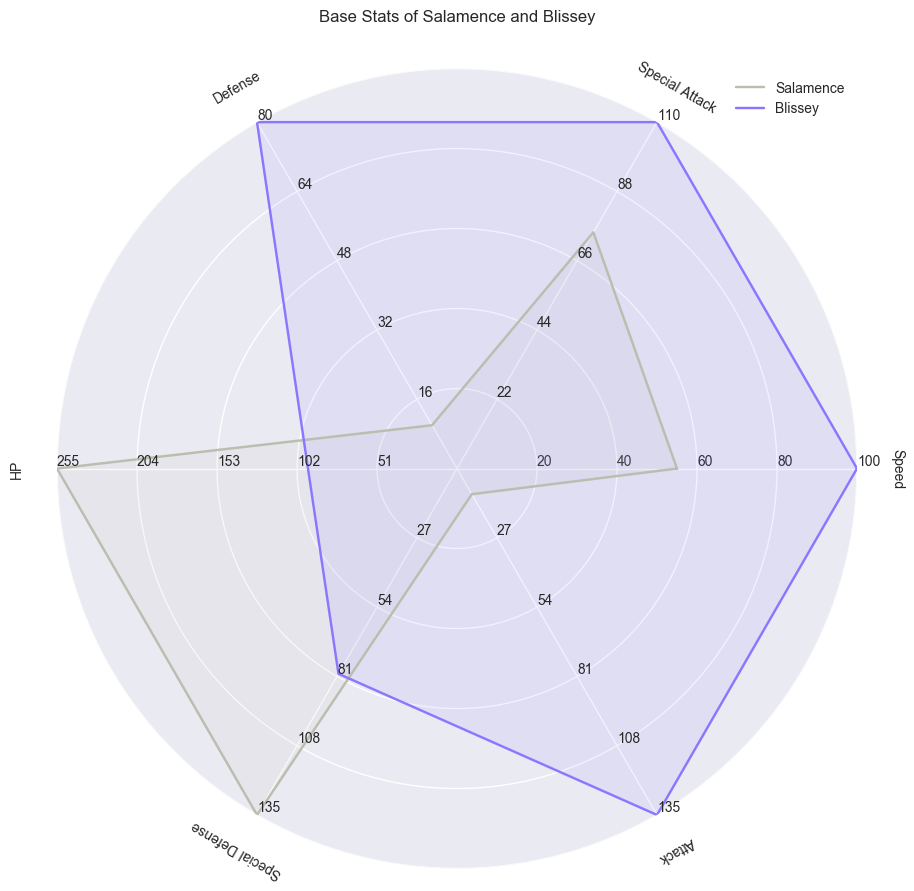

In [18]:
statSpread('SALAMENCE', 'BLISSEY', df, 0)

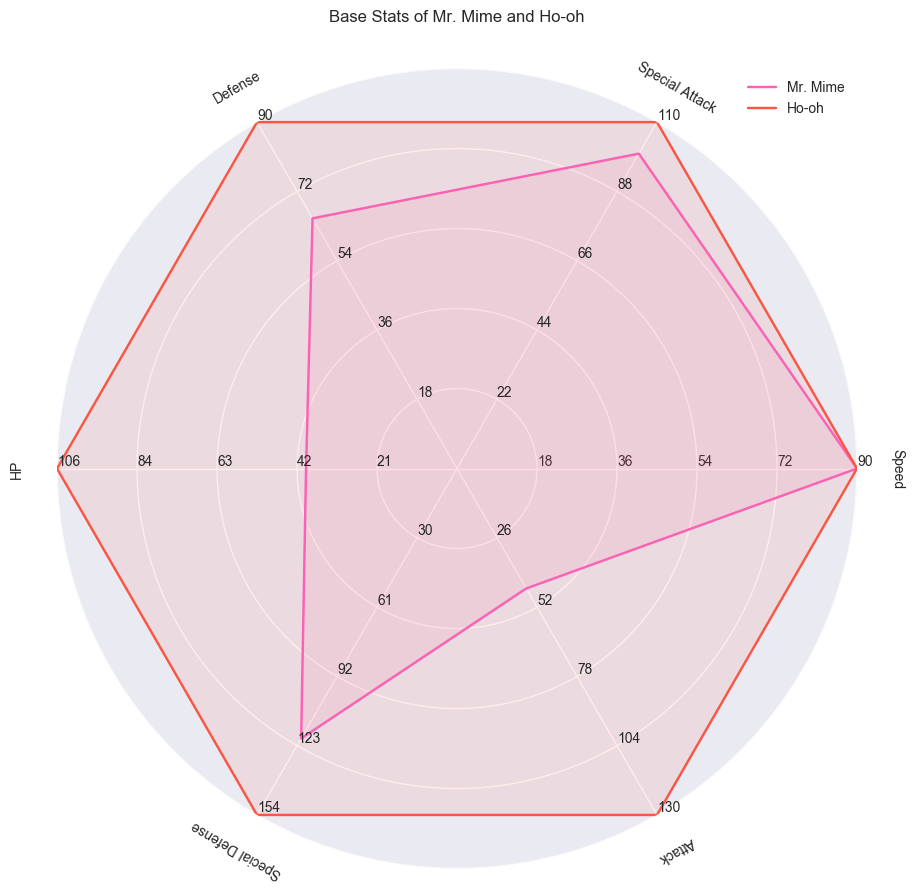

In [19]:
statSpread('MR. MIME', 'HO-OH', df, 1)

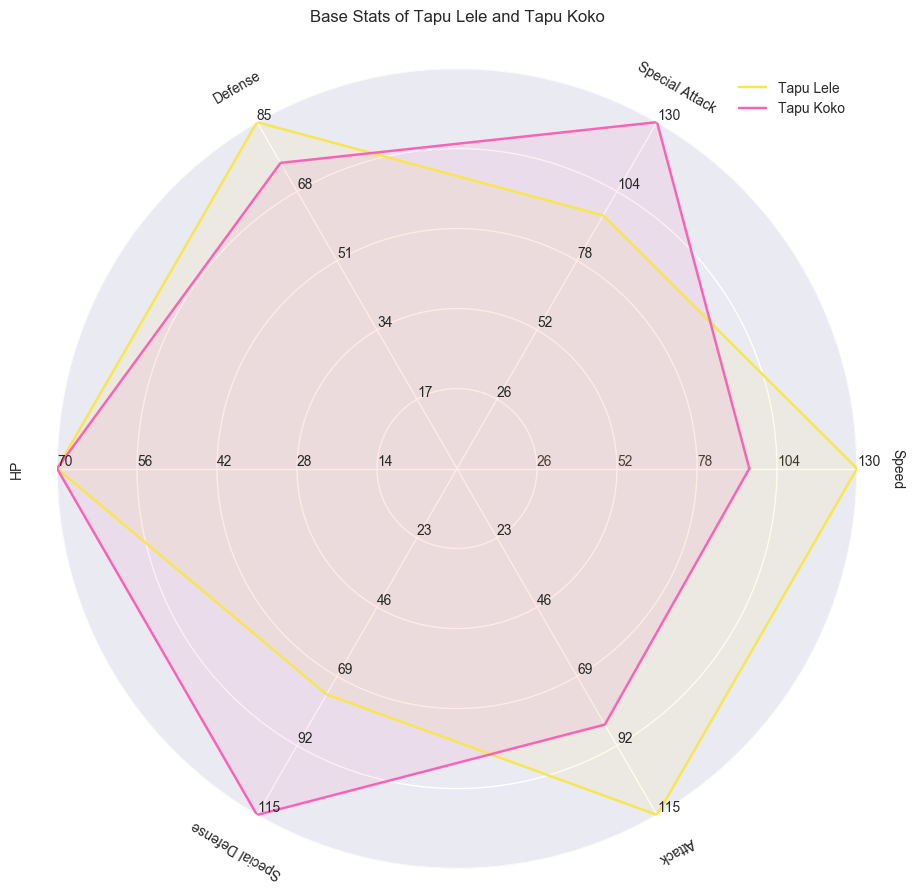

In [20]:
statSpread('TAPU LELE','TAPU KOKO',df, 2)